In [1]:
from helpers import * 
from processor import *

ic| cut_vertices: [7, 0]


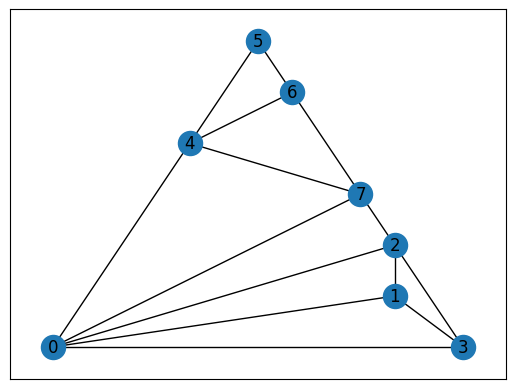

In [2]:
G_st = st_graph()   
p = Processor(G_st)
p.augment()
pos = plot_planar(p.G, p.embed)

ic| tri.target_edge: (0, 3)
ic| 'same y', n1_y: -0.3620689655172414, n2_y: -0.3620689655172414
ic| len(l3_cycles): 8, m: 16, n: 9, m - n + 1: 8


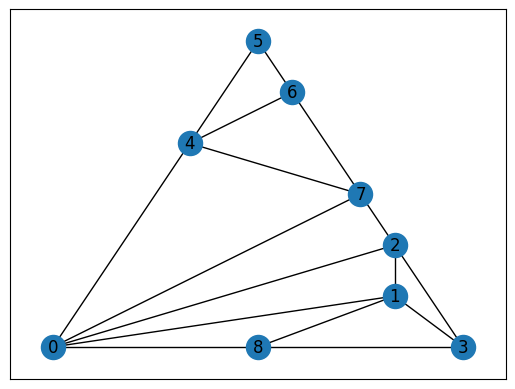

In [3]:
p.fix_separating_triangles()
plot_planar(p.G, p.s.embed)

ic| directions: {'east': (0.2873563218390804, -0.27011494252873564),
                 'north': (0.05747126436781608, 0.23563218390804597),
                 'south': (-0.5862068965517242, -0.3620689655172414),
                 'west': (-0.5862068965517242, -0.3620689655172414)}
ic| directions: {'east': (0.2873563218390804, -0.27011494252873564),
                 'north': (0.05747126436781608, 0.23563218390804597),
                 'south': (-0.5862068965517242, -0.3620689655172414),
                 'west': (-0.5402298850574713, 0.09770114942528735)}
ic| 'Passes planarity check'


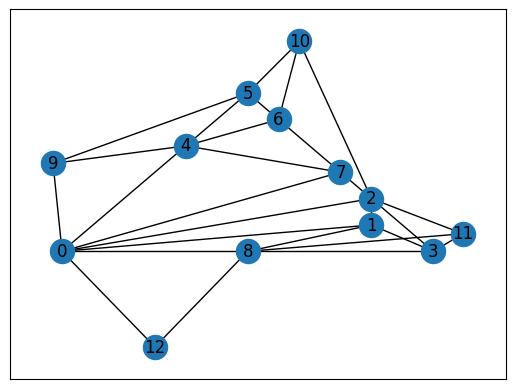

In [4]:
p.fix_cips()
p.add_corner_nodes()
plot_planar(p.b.G, p.b.embed)


In [5]:
corner_node_data = p.b.corner_node_data
def get_node_index(key):
    dict_key = get_key_by_value(corner_node_data, key, object=True)
    return corner_node_data[dict_key].node


In [6]:
corner_node_data

{0: CornerNode({'interior_nodes': [0, 4, 5], 'name': 'west', 'node': 9, 'location': (-1.0402298850574714, 0.09770114942528735), 'mean_location': (-0.5402298850574713, 0.09770114942528735)}),
 1: CornerNode({'interior_nodes': [5, 6, 2], 'name': 'north', 'node': 10, 'location': (0.05747126436781608, 0.735632183908046), 'mean_location': (0.05747126436781608, 0.23563218390804597)}),
 2: CornerNode({'interior_nodes': [2, 3, 8], 'name': 'east', 'node': 11, 'location': (0.7873563218390804, -0.27011494252873564), 'mean_location': (0.2873563218390804, -0.27011494252873564)}),
 3: CornerNode({'interior_nodes': [8, 0], 'name': 'south', 'node': 12, 'location': (-0.5862068965517242, -0.8620689655172413), 'mean_location': (-0.5862068965517242, -0.3620689655172414)})}

In [7]:
G = p.b.G.copy()
embed = p.b.embed

ix = get_node_index # create alias
edges = [(ix("south"), ix("east")),
         (ix("east"), ix("north")),
         (ix("north"), ix("west")),
         (ix("west"), ix("south")),
        #  (ix("south"), ix("north")),
         ]
G.add_edges_from(edges)

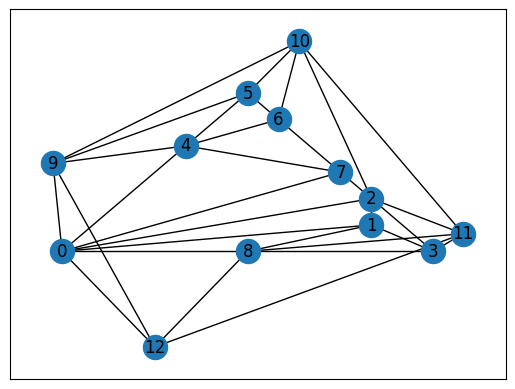

In [8]:
plot_planar(G, embed)

## start ordering... 

In [16]:
ic(v1, v2)
# candidate_nodes = [n for n in G.neighbors(v1) if n in G.neighbors(v2)]
candidate_nodes = [n for n in G_diff.neighbors(v1) if n in G_diff.neighbors(v2)]
candidate_nodes

# G_next is 

ic| v1: 9, v2: 0


AttributeError: 'set' object has no attribute 'neighbors'

In [18]:
# set canonical order of original 
G.nodes[get_node_index("south")]["canonical_order"] = 1
G.nodes[get_node_index("west")]["canonical_order"] = 2


# define the subgraph 
subgraph_nodes = []
subgraph_nodes.append(get_node_index("south"))
subgraph_nodes.append(get_node_index("west"))
G_k_minus = nx.subgraph(G, subgraph_nodes)
G_diff = set(G.nodes).difference(set(G_k_minus.nodes))


for order in range(2, len(G.nodes)):
    # find next node 
    v1 = subgraph_nodes[-2]
    v2 = subgraph_nodes[-1]
    candidate_nodes = [n for n in G.neighbors(v1) if n in G.neighbors(v2)]
    ic(candidate_nodes)


    # filter candidate nodes
    for node in candidate_nodes:
        true_candidate_nodes = []

        neighbours = {n for n in G.neighbors(node)}


        if len(G_diff.intersection(neighbours)) >= 2:
            true_candidate_nodes.append(node)

        assert true_candidate_nodes, "candidate nodes are invalid!"

    if len(true_candidate_nodes) == 1:
        pass # TODO break if only one node left.. 

    # dummy assignment for now
    next_node = true_candidate_nodes[0]
    ic(next_node)


    G.nodes[next_node]["canonical_order"] = order

    subgraph_nodes.append(next_node)
    G_k_minus = nx.subgraph(G, subgraph_nodes)
    G_diff = set(G.nodes).difference(set(G_k_minus.nodes))

ic| candidate_nodes: [0]
ic| next_node: 0
ic| candidate_nodes: [4, 12]
ic| next_node: 12
ic| candidate_nodes: [8, 9]
ic| next_node: 9
ic| candidate_nodes: [0]
ic| next_node: 0
ic| candidate_nodes: [4, 12]
ic| next_node: 12
ic| candidate_nodes: [8, 9]
ic| next_node: 9
ic| candidate_nodes: [0]
ic| next_node: 0
ic| candidate_nodes: [4, 12]
ic| next_node: 12
ic| candidate_nodes: [8, 9]
ic| next_node: 9
ic| candidate_nodes: [0]
ic| next_node: 0
ic| candidate_nodes: [4, 12]
ic| next_node: 12


In [12]:
G.nodes.data()

NodeDataView({0: {'corner_or_interior': 'interior', 'canonical_order': 11}, 1: {'corner_or_interior': 'interior'}, 2: {'corner_or_interior': 'interior'}, 3: {'corner_or_interior': 'interior'}, 4: {'corner_or_interior': 'interior'}, 5: {'corner_or_interior': 'interior'}, 6: {'corner_or_interior': 'interior'}, 7: {'corner_or_interior': 'interior'}, 8: {'corner_or_interior': 'interior'}, 9: {'corner_or_interior': 'corner', 'canonical_order': 10}, 10: {'corner_or_interior': 'corner'}, 11: {'corner_or_interior': 'corner'}, 12: {'corner_or_interior': 'corner', 'canonical_order': 12}})

In [9]:
# let v1 = vs, v2 = vw. (these get added to graph Gk-1)
subgraph_nodes = []

subgraph_nodes.append(get_node_index("south"))
subgraph_nodes.append(get_node_index("west"))

G.nodes[get_node_index("south")]["canonical_order"] = 1
G.nodes[get_node_index("west")]["canonical_order"] = 2

In [10]:
G.nodes.data()

NodeDataView({0: {'corner_or_interior': 'interior'}, 1: {'corner_or_interior': 'interior'}, 2: {'corner_or_interior': 'interior'}, 3: {'corner_or_interior': 'interior'}, 4: {'corner_or_interior': 'interior'}, 5: {'corner_or_interior': 'interior'}, 6: {'corner_or_interior': 'interior'}, 7: {'corner_or_interior': 'interior'}, 8: {'corner_or_interior': 'interior'}, 9: {'corner_or_interior': 'corner', 'canonical_order': 2}, 10: {'corner_or_interior': 'corner'}, 11: {'corner_or_interior': 'corner'}, 12: {'corner_or_interior': 'corner', 'canonical_order': 1}})

In [11]:
G.nodes[get_node_index("south")]

{'corner_or_interior': 'corner', 'canonical_order': 1}

In [12]:
G_k_minus = nx.subgraph(G, subgraph_nodes)
G_k_minus.nodes #.add_node(G.nodes[get_node_index("south")])

NodeView((9, 12))

In [13]:
subgraph_nodes[-2]

12

In [19]:
# candidate v3 -> node that is neighbour to v2 and v1
v1 = subgraph_nodes[-2]
v2 = subgraph_nodes[-1]
candidate_nodes = [n for n in G.neighbors(v1) if n in G.neighbors(v2)]
candidate_nodes


[0]

In [32]:


# todo will iterate over this when there are many .. 
# filter candidate nodes
for node in candidate_nodes:
    true_candidate_nodes = []

    neighbours = {n for n in G.neighbors(node)}
    neighbours
    ic(G_diff, neighbours);

    if len(G_diff.intersection(neighbours)) >= 2:
        true_candidate_nodes.append(node)

    assert true_candidate_nodes, "candidate nodes are invalid!"

if len(true_candidate_nodes) == 1:
    pass # TODO break if only one node left.. 

ic| G_diff: {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}
    neighbours: {1, 2, 5, 7, 8, 9, 12}


In [36]:
len(G.nodes)

13

In [38]:
for i in range(2, len(G.nodes)):
    print(i)

2
3
4
5
6
7
8
9
10
11
12


In [ ]:
# just assign values for now .. 
G.nodes[true_candidate_nodes[0]]["canonical_order"] = 3
subgraph_nodes.append(true_candidate_nodes[0])
G_k_minus = nx.subgraph(G, subgraph_nodes)
G_diff = set(G.nodes).difference(set(G_k_minus.nodes))


In [35]:
# todo sort by distance (maybe from v1..) and check other parts of the theorem.. 
pos = [embed[n] for n in true_candidate_nodes]
pos

[array([-1.        , -0.36206897])]

In [33]:
true_candidate_nodes

[0]